In [5]:
%matplotlib inline
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import plotly.graph_objects as go
from typing import Dict, Any, Optional
import plotly.express as px
import ast

plt.style.use("../plt_plot_style.mplstyle")
f_name = "../project.csv"
# df = pd.read_csv(f_name)
# df.head()
# df.shape
df = pd.read_csv("../processed_results.csv", index_col="id")

/tmp/ipykernel_218153/4200731175.py:18: DtypeWarning: Columns (13,14,15,18,19,20,21,22,24,25,26,27,29,31,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,

In [3]:
_NAN_TOKEN="N/A"
_TARGET_KEYS=[
    "accuracy",
    "best_accuracy",
    "ITOP Rate",
    "_TOTAL_PERCENTAGE_ACTIVE_NEURONS",
    
]

In [4]:
def parse_wandb_results(project_results_csv: str) -> pd.DataFrame:
    df = pd.read_csv(project_results_csv)
    df = df.set_index("id")
    config_df = df["config"].apply(lambda x: pd.json_normalize(ast.literal_eval(x)))
    config_df = pd.concat(config_df.to_dict())
    config_df.index = df.index
    summary_df = df["summary"].apply(lambda x: pd.json_normalize(ast.literal_eval(x)))
    summary_df = pd.concat(summary_df.to_dict())
    summary_df.index = df.index
    combined_df = pd.concat([df[["name", "state"]], config_df, summary_df,], axis=1)
    sorted_cols = sorted(combined_df.columns)
    combined_df = combined_df[sorted_cols]
    return combined_df

# combined_df = parse_wandb_results("../project.csv")

In [5]:
# combined_df.to_csv("../processed_results.csv")

In [166]:
def model_state_filter(df, epoch=250):
    return df.loc[(df["state"]=="finished") & (df["epoch"]==epoch)]

def get_model_name_filter(df, model_name):
    return df.loc[((df['model.name']==model_name) | (df['model']==model_name))] 

def get_sparse_grad_flow(df):
    return df.loc[df["rigl.init_method_str"] == "grad_flow_init"]

def get_sparse_saliency(df):
    return df[df["name"].str.contains("salients_only")]

def get_model_results(df, model_name="resnet18", expected_epochs=250):
    model_df = model_state_filter(df, expected_epochs)
    model_df = get_model_name_filter(model_df, model_name)
    # model_df = get_sparse_grad_flow(model_df)
    # model_df = get_sparse_saliency(model_df)
    return model_df


resnet18=get_model_results(df, "resnet18", 250)
wide_resnet22=get_model_results(df, "wide_resnet22", 250)
imagenet=get_model_results(df, "resnet50", 103)

In [165]:
imagenet[["rigl.dense_allocation", "accuracy"]]

,rigl.dense_allocation,accuracy
id,,
3rk8eon8,0.01,0.50652


In [167]:
display_group_by(imagenet, groupby_vars=["rigl.const_fan_in", "rigl.dense_allocation"])

rigl.const_fan_in  rigl.dense_allocation
False              0.10                     0.719360
True               0.10                     0.712910
                   0.01                     0.502172
Name: accuracy, dtype: float64

In [158]:
get_model_name_filter(df, "resnet50").groupby(["rigl.const_fan_in", "rigl.dense_allocation"]).count()

ITOP Rate  Learning Rate  \
rigl.const_fan_in rigl.dense_allocation                             
False             0.01                           1              2   
                  0.10                           2              5   
True              0.01                          10             11   
                  0.10                           3              9   

                                         Training Loss  _PRUNING_RATE  \
rigl.const_fan_in rigl.dense_allocation                                 
False             0.01                               0              0   
                  0.10                               0              0   
True              0.01                               8              8   
                  0.10                               2              2   

                                         _TOTAL_ACTIVE_NEURONS  \
rigl.const_fan_in rigl.dense_allocation                          
False             0.01                                       0   
                  0.10                                       0   
True              0.01                                       8   
                  0.10                                       2   

                                         _TOTAL_PERCENTAGE_ACTIVE_NEURONS  \
rigl.const_fan_in rigl.dense_allocation                                     
False             0.01                                                  0   
                  0.10                                                  0   
True              0.01                                                  8   
                  0.10                                                  2   

                                         _runtime  _step  _timestamp  \
rigl.const_fan_in rigl.dense_allocation                                
False             0.01                          2      2           2   
                  0.10                          5      5           5   
True              0.01                         11     11          11   
                  0.10                          9      9           9   

                                         _wandb.runtime  ...  \
rigl.const_fan_in rigl.dense_allocation                  ...   
False             0.01                                1  ...   
                  0.10                                3  ...   
True              0.01                                9  ...   
                  0.10                                8  ...   

                                         z-module.layer4.2.conv3-Max-Grad-Per-Filter.values  \
rigl.const_fan_in rigl.dense_allocation                                                       
False             0.01                                                                   0    
                  0.10                                                                   0    
True              0.01                                                                   8    
                  0.10                                                                   2    

                                         z-module.layer4.2.conv3-Max-Inactive_Grad  \
rigl.const_fan_in rigl.dense_allocation                                              
False             0.01                                                           0   
                  0.10                                                           0   
True              0.01                                                           8   
                  0.10                                                           2   

                                         z-module.layer4.2.conv3-Max-Inactive_Weight  \
rigl.const_fan_in rigl.dense_allocation                                                
False             0.01                                                             0   
                  0.10                                                             0   
True              0.01                                               

In [151]:
get_model_name_filter(df, "resnet50").loc[df["epoch"]==102][['name', "accuracy"]]

,name,accuracy
id,,
xhnqnd6c,resnet50_imagenet_dense_alloc=0.01_const_fan=F...,0.51386
2d4v4ezc,resnet50_imagenet_dense_alloc=0.01_const_fan=True,0.51196
8w8lu0dy,resnet50_imagenet_0.1_True_hector-test,0.69432
3b64l2u6,resnet50_imagenet_dense_alloc=None_const_fan=T...,0.76738


In [32]:
def display_group_by(df, groupby_vars, sort_by = "accuracy"):
    return df.groupby(groupby_vars).mean().sort_values(by=sort_by, ascending=False)[sort_by]

display(display_group_by(wide_resnet22, ["rigl.dense_allocation", "rigl.min_salient_weights_per_neuron"]))

rigl.dense_allocation  rigl.min_salient_weights_per_neuron
0.10                   0.100                                  0.930260
                       0.010                                  0.930200
                       0.050                                  0.929780
                       0.005                                  0.928880
                       0.001                                  0.928830
                       0.000                                  0.928420
                       1.000                                  0.928167
0.05                   0.100                                  0.915660
                       1.000                                  0.915500
                       0.005                                  0.915100
                       0.001                                  0.914700
                       0.010                                  0.914120
                       0.050                                  0.913920
                  

In [33]:
display(display_group_by(resnet18, ["rigl.dense_allocation", "rigl.min_salient_weights_per_neuron"]))

rigl.dense_allocation  rigl.min_salient_weights_per_neuron
0.10                   0.005                                  0.949860
                       0.100                                  0.949720
                       0.050                                  0.949500
                       1.000                                  0.949200
                       0.001                                  0.949040
                       0.010                                  0.948620
                       0.000                                  0.948340
0.05                   0.100                                  0.946860
                       0.050                                  0.946360
                       0.005                                  0.946320
                       0.001                                  0.945880
                       0.010                                  0.945540
                       1.000                                  0.945360
                  

In [ ]:
# Based on above, use 0.005 as min-salient

In [63]:
## Resnet runs
old_run_ids = [
    "1wpb02dh",
    "mqb2j0y3",
    "2mbi1968",
    "2o7r4f32",
    "2zghy7cs",
    "24ju3o5b",
    "3bu1wts2",
    # wide resnets
    "200dfvfl",
    "z43wsdbk",
    "21ymka9z",
    "20tipo0l",
    "36u2ugju",
    "3ach3s6f",
    "36sa93oj",
    "ashld1px",
    "r59jeqa6",
    "1idniv9f",
]
old_resnet18_runs = ['1wpb02dh',
 'mqb2j0y3',
 '2mbi1968',
 '2o7r4f32',
 '2zghy7cs',
 '24ju3o5b',
 '3bu1wts2']

In [76]:
resnet18 = model_state_filter(df)
resnet18 = get_model_name_filter(resnet18, "resnet18")
other_runs = []
sparsities = [0.2,0.3,0.4,0.5]
for s in sparsities:
    other_runs.extend(
        resnet18.loc[
            (resnet18["rigl.const_fan_in"]==True) & \
            (resnet18["rigl.min_salient_weights_per_neuron"].isna()) &\
            (resnet18["rigl.dense_allocation"] == s)
        ].index.to_list()
    )

new_high_sparse_ids = resnet18.loc[
    (resnet18["rigl.const_fan_in"]==True) & \
    (resnet18["rigl.min_salient_weights_per_neuron"] == 0.005) & \
    (resnet18["rigl.use_sparse_const_fan_in_for_ablation"] == True)
].index.to_list()


vanilla_ids = []
for s in [0.01, 0.05, 0.1, 0.2, 0.3 ,0.4, 0.5]:
    vanilla_ids.extend(
        resnet18.loc[
            (resnet18["rigl.const_fan_in"]==False) & \
            (resnet18["rigl.min_salient_weights_per_neuron"].isna()) &\
            (resnet18["rigl.dense_allocation"] == s) & \
            (resnet18["name"].str.contains("resnet18_cifar10_sweep_"))
        ].index.to_list()
    )

print(df.loc[vanilla_ids].groupby("rigl.dense_allocation").count()['accuracy'])
print(df.loc[new_high_sparse_ids].groupby("rigl.dense_allocation").count()['accuracy'])
print(df.loc[other_runs].groupby("rigl.dense_allocation").count()['accuracy'])

rigl.dense_allocation
0.01    5
0.05    5
0.10    5
0.20    5
0.30    5
0.40    5
0.50    5
Name: accuracy, dtype: int64
rigl.dense_allocation
0.01    5
0.05    5
0.10    5
Name: accuracy, dtype: int64
rigl.dense_allocation
0.2    8
0.3    7
0.4    5
0.5    5
Name: accuracy, dtype: int64


In [83]:
df.loc[other_runs].groupby(["rigl.dense_allocation", "training.seed"]).count()

ITOP Rate  Learning Rate  Training Loss  \
rigl.dense_allocation training.seed                                            
0.2                   42.0                   0              2              0   
                      2078.0                 0              2              0   
                      6037.0                 0              1              0   
                      7303.0                 0              2              0   
                      8746.0                 0              1              0   
0.3                   42.0                   0              1              0   
                      2078.0                 0              1              0   
                      6037.0                 0              2              0   
                      7303.0                 0              1              0   
                      8746.0                 0              2              0   
0.4                   42.0                   0              1              0   
                      2078.0                 0              1              0   
                      6037.0                 0              1              0   
                      7303.0                 0              1              0   
                      8746.0                 0              1              0   
0.5                   42.0                   0              1              0   
                      2078.0                 0              1              0   
                      6037.0                 0              1              0   
                      7303.0                 0              1              0   
                      8746.0                 0              1              0   

                                     _PRUNING_RATE  _TOTAL_ACTIVE_NEURONS  \
rigl.dense_allocation training.seed                                         
0.2                   42.0                       0                      0   
                      2078.0                     0                      0   
                      6037.0                     0                      0   
                      7303.0                     0                      0   
                      8746.0                     0                      0   
0.3                   42.0                       0                      0   
                      2078.0                     0                      0   
                      6037.0                     0                      0   
                      7303.0                     0                      0   
                      8746.0                     0                      0   
0.4                   42.0                       0                      0   
                      2078.0                     0                      0   
                      6037.0                     0                      0   
                      7303.0                     0                      0   
                      8746.0                     0                      0   
0.5                   42.0                       0                      0   
                      2078.0                     0                      0   
                      6037.0                     0                      0   
                      7303.0                     0                      0   
                      8746.0                     0                      0   

                                     _TOTAL_PERCENTAGE_ACTIVE_NEURONS  \
rigl.dense_allocation training.seed                                     
0.2                   42.0                                          0   
                      2078.0                                        0   
                      6037.0                                        0   
                      7303.0                                        0   
                      8746.0                                        0   
0.3                   42.0                                          0 

In [88]:
resnet_ids = vanilla_ids + new_high_sparse_ids + other_runs
len(resnet_ids)

75

In [119]:
model_name="wide_resnet22"
model_df = model_state_filter(df)
model_df = get_model_name_filter(model_df, model_name)
wide_net_low_sparse_runs = []
wide_net_high_sparse_vanilla=[]
densities = [0.2,0.3,0.4,0.5,]
for d in densities:
    wide_net_low_sparse_runs.extend(
        model_df.loc[
            (model_df["rigl.min_salient_weights_per_neuron"].isna()) &\
            (model_df["rigl.dense_allocation"] == d) & \
            (model_df["rigl.grad_accumulation_n"]!=8)
        ].index.to_list()
    )
densities = [0.1,0.05,0.01]
for d in densities:
    wide_net_high_sparse_vanilla.extend(
        model_df.loc[
            (model_df["rigl.const_fan_in"]==False) & \
            (model_df["rigl.min_salient_weights_per_neuron"].isna()) &\
            (model_df["rigl.dense_allocation"] == d) & \
            (model_df["rigl.grad_accumulation_n"]!=8) & \
            (model_df["name"].str.contains("wide_resnet22_cifar10_sweep"))
        ].index.to_list()
    )
    
wide_res_net_ids_min_salient_005=wide_resnet22.loc[wide_resnet22["rigl.min_salient_weights_per_neuron"] ==  0.005].index.to_list()
wide_res_ids=wide_res_net_ids_min_salient_005+wide_net_high_sparse_vanilla+wide_net_low_sparse_runs
len(wide_res_ids)

70

In [121]:
# wide_net_runs.loc[wide_net_runs]
display(display_group_by(df.loc[wide_res_ids], ["rigl.dense_allocation", "rigl.const_fan_in"]))

rigl.dense_allocation  rigl.const_fan_in
0.50                   True                 0.94660
                       False                0.94456
0.40                   False                0.94374
                       True                 0.94364
0.30                   False                0.94294
                       True                 0.94280
0.20                   False                0.94062
                       True                 0.93804
0.10                   False                0.93168
                       True                 0.92888
0.05                   False                0.91600
                       True                 0.91510
0.01                   False                0.84700
                       True                 0.81832
Name: accuracy, dtype: float64

In [50]:
df.loc[other_wide_resnet_runs+wide_resnet22.index.to_list()].groupby(["rigl.dense_allocation", "rigl.const_fan_in", "rigl.use_sparse_const_fan_in_for_ablation"]).count()['accuracy']

rigl.dense_allocation  rigl.const_fan_in  rigl.use_sparse_const_fan_in_for_ablation
0.01                   True               True                                         35
0.05                   True               True                                         35
0.10                   True               True                                         51
Name: accuracy, dtype: int64

70

In [89]:
df.loc[wide_res_net_ids_min_salient_005].groupby(["rigl.dense_allocation"]).count()["accuracy"]

rigl.dense_allocation
0.01    5
0.05    5
0.10    5
Name: accuracy, dtype: int64

In [ ]:
## Imagenet runs

## PLOTTING

In [111]:
def get_confidence_bounds_df(df: pd.DataFrame, alpha=0.95, target_col:str = "accuracy"):
    df = df.copy()
    df = df.loc[~df[target_col].isna()]
    results = {
        "sparsity":[],
        "mean":[],
        "lower_bound":[],
        "upper_bound":[],
    }
    for sparsity in df["sparsity"].unique():
        this_df = df.loc[df["sparsity"] == sparsity]
        results["sparsity"].append(sparsity)
        results["mean"].append(this_df[target_col].mean())
        lower, upper = st.t.interval(
            alpha=alpha,
            df=len(this_df[target_col])-1,
            loc=this_df[target_col].mean(),
            scale=st.sem(this_df[target_col])
        )
        results["lower_bound"].append(lower)
        results["upper_bound"].append(upper)
    return pd.DataFrame(results)

In [113]:
## Style sheet: 
style = """
# Figure properties
figure.figsize: 10, 6 # figure size in inches

# Font properties
font.size: 16 # Size of the font
font.family: sans-serif # Type of Font
font.sans-serif : "DejaVu Sans"


# Axes properties
axes.linewidth: 2  # edge linewidth
axes.labelpad: 8   # space between label and axis
axes.prop_cycle: cycler(color=['00a5bb','f79141','499585', 'd81e52', '6cb2c5' , '6c77c5', 'c5ba6c', '56ce93', 'd88fBf', 'ffd505']) # color cycle for plot lines
axes.titlepad: 20.0    # pad between axes and title in points
axes.labelsize: 16     # Axes labels size
axes.titlesize: 20     # Plot title size
axes.labelweight: 500  # Axel Labels weight
axes.titleweight: 500  # Axel Titleweight
axes.edgecolor: 262626
axes.labelcolor: 262626
axes.titlecolor: 262626

# Tick properties
# x-axis
xtick.direction: inout # direction: in, out, or inout
xtick.major.size: 0 # major tick size in points
xtick.major.width: 0 # major tick width in points
xtick.minor.size: 0 # minor tick size in points
xtick.minor.width: 0 # minor tick width in points
xtick.major.pad : 10
xtick.minor.pad: 10
xtick.labelsize : 16

# y-axis
ytick.direction: inout # direction: in, out, or inout
ytick.major.size: 0 # major tick size in points
ytick.major.width: 0 # major tick width in points
ytick.minor.size: 0 # minor tick size in points
ytick.minor.width: 0 # minor tick width in points
ytick.major.pad : 10
ytick.minor.pad: 10
ytick.labelsize : 16

# Line properties
lines.linewidth: 3.5

# Legend properties
legend.framealpha: 0.8  # opacity of legend frame
legend.frameon: False   # whether or not to draw a frame around legend
legend.fontsize: 14     # Font size of the legend
legend.borderpad : 0
#legend.borderaxespad: 1.5

#Edge Color properties
#patch.force_edgecolor: True #Edge color for the bars
"""
with open("plt_plot_style.mplstyle", "w") as handle:
  handle.write(style)

plt.style.use("./plt_plot_style.mplstyle")

,sparsity,mean,lower_bound,upper_bound
0,0.99,0.81832,0.810072,0.826568
1,0.95,0.91510,0.912073,0.918127
2,0.90,0.92888,0.927244,0.930516
3,0.80,0.93804,0.934372,0.941708
4,0.70,0.94280,0.940507,0.945093
5,0.60,0.94364,0.939933,0.947347
6,0.50,0.94660,0.944851,0.948349


,sparsity,mean,lower_bound,upper_bound
0,0.99,0.84700,0.841470,0.852530
1,0.95,0.91600,0.913741,0.918259
2,0.90,0.93168,0.929780,0.933580
3,0.80,0.94062,0.939124,0.942116
4,0.70,0.94294,0.940090,0.945790
5,0.60,0.94374,0.941954,0.945526
6,0.50,0.94456,0.943050,0.946070


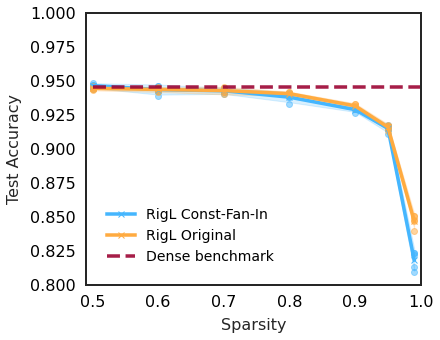

In [134]:
model_name = "wide_resnet22"
_IDS = wide_res_ids
_PLOT_99_SPARSITY= True
_BENCHMARK_VALUE = 0.9455

plot_df = df.loc[_IDS].copy().sort_values(by="rigl.dense_allocation")
plot_df = plot_df.loc[plot_df["state"] == "finished"]
if not _PLOT_99_SPARSITY:
  plot_df = plot_df.loc[plot_df["rigl.dense_allocation"] != 0.01]
# plot_df = plot_df.loc[plot_df["model"] == _MODEL]
plot_df["sparsity"] = 1-plot_df["rigl.dense_allocation"]
plot_dfs = []
fig, ax = plt.subplots(figsize=(6,5))
colors = ['#45b6fe','#ffab40','#9c0534'] # '#ffab40' '#ff671f'


for idx, fan_in in enumerate(plot_df["rigl.const_fan_in"].unique()):
    df_slice = plot_df.loc[plot_df["rigl.const_fan_in"] == fan_in]
    if fan_in:
        name = "RigL Const-Fan-In"
    else:
        name = "RigL Original"
    agg_results = get_confidence_bounds_df(df_slice)
    display(agg_results)
    ax.plot(
        agg_results["sparsity"], agg_results["mean"], marker='x', label=name, color=colors[idx], alpha=1.0
    )
    ax.fill_between(
        agg_results["sparsity"],
        agg_results["upper_bound"],
        agg_results["lower_bound"],
        color=colors[idx],
        alpha=0.20)
    ax.scatter(
        df_slice["sparsity"], df_slice["accuracy"], marker='o', color=colors[idx], alpha=0.5
    )

ax.plot([0.5, 1.0], [_BENCHMARK_VALUE, _BENCHMARK_VALUE], "--",  label="Dense benchmark", color=colors[2], alpha=0.9)
model_name_dict = dict(
    resnet18="ResNet18",
    wide_resnet22="WideResNet22"
)
#plt.title(f"{model_name_dict[_MODEL]} CIFAR-10 Validation Set Accuracy vs. Sparsity")
plt.xlabel('Sparsity')
plt.ylabel('Test Accuracy')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
# if not _PLOT_99_SPARSITY:
ax.set_ylim([0.80,1.0])
ax.set_xlim([0.49,1.0])
# else:
#   ax.set_ylim([0.9,1.0])
#   ax.set_xlim([0.49,1.0])
plt.show()

fig.savefig(f"{model_name}_cifar_results.png", dpi=600, bbox_inches="tight")
fig.savefig("Experiment.svg",format="svg", bbox_inches="tight")


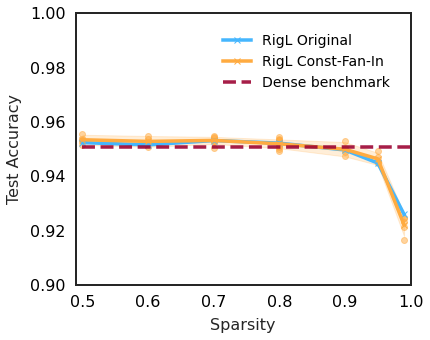

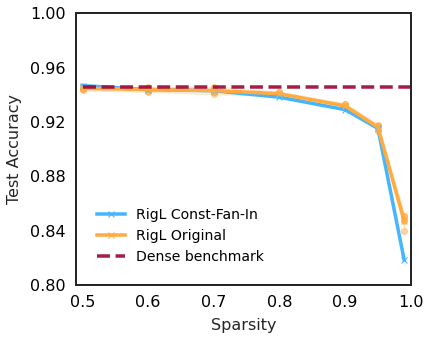

In [142]:
def get_accuracy_vs_sparsity_plot(model_name, ids, dense_benchmark_value, plot_99_sparsity=True, ylim=[0.9,1.0]):
    _BENCHMARK_VALUE = 0.9506

    plot_df = df.loc[ids].copy().sort_values(by="rigl.dense_allocation")
    plot_df = plot_df.loc[plot_df["state"] == "finished"]
    if not plot_99_sparsity:
      plot_df = plot_df.loc[plot_df["rigl.dense_allocation"] != 0.01]
    plot_df["sparsity"] = 1-plot_df["rigl.dense_allocation"]
    plot_dfs = []
    fig, ax = plt.subplots(figsize=(6,5))
    colors = ['#45b6fe','#ffab40','#9c0534'] # '#ffab40' '#ff671f'


    for idx, fan_in in enumerate(plot_df["rigl.const_fan_in"].unique()):
        df_slice = plot_df.loc[plot_df["rigl.const_fan_in"] == fan_in]
        if fan_in:
            name = "RigL Const-Fan-In"
        else:
            name = "RigL Original"
        agg_results = get_confidence_bounds_df(df_slice)
        # display(agg_results)
        ax.plot(
            agg_results["sparsity"], agg_results["mean"], marker='x', label=name, color=colors[idx], alpha=1.0
        )
    ax.fill_between(
        agg_results["sparsity"],
        agg_results["upper_bound"],
        agg_results["lower_bound"],
        color=colors[idx],
        alpha=0.20
    )
    ax.scatter(
        df_slice["sparsity"], df_slice["accuracy"], marker='o', color=colors[idx], alpha=0.5
    )

    ax.plot([0.5, 1.0], [dense_benchmark_value, dense_benchmark_value], "--",  label="Dense benchmark", color=colors[2], alpha=0.9)
    model_name_dict = dict(
        resnet18="ResNet18",
        wide_resnet22="WideResNet22"
    )
    #plt.title(f"{model_name_dict[_MODEL]} CIFAR-10 Validation Set Accuracy vs. Sparsity")
    plt.xlabel('Sparsity')
    plt.ylabel('Test Accuracy')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)
    ax.set_ylim(ylim)
    ax.set_xlim([0.49,1.0])
    tick_spaces=5
    y_tick_eps = (max(ylim) - min(ylim))/tick_spaces
    y_ticks = [min(ylim)+y_tick_eps*x for x in range(tick_spaces+1)]
    ax.set_yticks(y_ticks)
    fig_name = f"{model_name}_cifar_results"
    fig.savefig(f"{model_name}.png", dpi=600, bbox_inches="tight")
    fig.savefig(f"{model_name}.svg",format="svg", bbox_inches="tight")
    return fig

resnet18_params=dict(
    ids = resnet_ids,
    model_name ="resnet18",
    dense_benchmark_value = 0.9506,
    plot_99_sparsity=True
)

wide_resnet22_params=dict(
    ids = wide_res_ids,
    model_name ="wide_resnet22",
    dense_benchmark_value = 0.9455,
    plot_99_sparsity=True,
    ylim=[0.8,1.0]
)

fig = get_accuracy_vs_sparsity_plot(**resnet18_params)
# fig.show()
fig = get_accuracy_vs_sparsity_plot(**wide_resnet22_params)
fig.show()
